## Table of content:
* [Loading Data](#first-bullet)
* [Feature Engineering](#second-bullet)
* [Algorithms & Search](#second-bullet)
* [Final Model](#second-bullet)
* [Evaluation Metrics](#second-bullet)
* [Conclusion](#second-bullet)
* [Performance & Potential improvements](#second-bullet)

In [ ]:
#!pip install rfpimp

In [19]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer, MissingIndicator
from pandas.core.common import SettingWithCopyWarning
from rfpimp import *
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Spam vs. Ham -  UCI Spambase Data Set
-----

### Research Question / Hypothesis:
Predict spam vs. non-spam emails - Moreover, how can we detect as many true positives (correctly classified spam emails) while limiting false positives (wrongly classified spam emails).

# Loading Data
-----

Load the data and split it up into a train and test set of appropriate size. The test set will be used for the final model evaluation, while the training set will be used for the cross-validation. 

In [6]:
spam_data = pd.read_csv('data/spambase_with_header.data')

target = spam_data['class']
data_features = spam_data.drop("class", axis=1)

# takes a 85/15 train and test split
X_train, X_test, y_train, y_test = train_test_split(
    data_features, target, test_size=0.15)

# Feature Engineering
-----

Below is some feature engineering that is included in my pipeline. It adds two columns to the dataset, the sum of the word frequency columns and the sum of the char frequency columns.

In [13]:
# class from https://stackoverflow.com/questions/65157478/creating-new-pandas-dataframe-column-within-pipeline-process
class FuncColumnTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# sums word_freq columns
def sum_word_freq(df):
    column_list = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
                   'word_freq_our', 'word_freq_over', 'word_freq_remove',
                   'word_freq_internet', 'word_freq_order', 'word_freq_mail',
                   'word_freq_receive', 'word_freq_will', 'word_freq_people',
                   'word_freq_report', 'word_freq_addresses', 'word_freq_free',
                   'word_freq_business', 'word_freq_email', 'word_freq_you',
                   'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
                   'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
                   'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
                   'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
                   'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
                   'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
                   'word_freq_original', 'word_freq_project', 'word_freq_re',
                   'word_freq_edu', 'word_freq_table', 'word_freq_conference']
    df.loc[:, 'sum_word_freq'] = df.loc[:, column_list].sum(axis=1)
    return df

# sums char_freq_ columns
def sum_char_freq(df):
    column_list = ['char_freq_%3B', 'char_freq_%28', 'char_freq_%5B', 'char_freq_%21',
                   'char_freq_%24', 'char_freq_%23']
    df.loc[:, 'sum_char_freq'] = df.loc[:, column_list].sum(axis=1)
    return df

# Algorithms & Search
-----

Searching through algorithms, I found that ExtraTreesClassifier and RandomForestClassifier performed well on this classification task. Bellow, I used RandomizedSearchCV to find the best performing model with the best hyperparameter between these two models. As part of my RandomizedSearchCV I am trying to optimize my f1 score to find a good balance between precision and recall. I also experimented with tunning the model towards a high precision score but this sacrificed a lot on both recall and f1 performance. 

In [16]:
algorithms = (
    [ExtraTreesClassifier(),
     {
         # for generality
        'model__max_depth': range(5, 25, 1),
        # different loss function for choosing split
        'model__criterion': ['entropy', 'gini'],
        # to better average tree predictions and reduce varriance
        'model__n_estimators': range(10, 100, 10),
        # for generality
        'model__max_features': ['log2', 'sqrt', 'auto'],
        # for generelizablity
        'model__min_samples_leaf': range(1, 10, 2),
    }],
    [RandomForestClassifier(),
     {
        # hyperparameter tunning importance same as above
        'model__max_depth': range(5, 25, 1),
        'model__n_estimators': range(10, 100, 10),
        'model__min_samples_leaf': range(1, 10, 2),
        'model__max_features': ['log2', 'sqrt', 'auto'],
        'model__oob_score': [True, False]
    }])


for model, model_params in algorithms:
    pipe = Pipeline([
        # applies feature engineering specified above
        ('transformer_word_sum', FuncColumnTransformer(sum_word_freq)),
        ('transformer_char_sum', FuncColumnTransformer(sum_char_freq)),
        # deals with missing values in train and test set
        ('imputer', IterativeImputer(max_iter=10)),
        ('model', model)
    ])

    cv = RandomizedSearchCV(estimator=pipe,
                            param_distributions=model_params,
                            n_iter=25,
                            cv=10,
                            n_jobs=-1,
                            # focus on increasing f1_score
                            scoring=make_scorer(f1_score, greater_is_better=True))

    cv.fit(X_train, y_train)

    print(model, '\n'*2, cv.best_estimator_, cv.best_score_)

ExtraTreesClassifier() 

 Pipeline(steps=[('transformer_word_sum',
                 <__main__.FuncColumnTransformer object at 0x7ff7c48911f0>),
                ('transformer_char_sum',
                 <__main__.FuncColumnTransformer object at 0x7ff7c4891a00>),
                ('i', IterativeImputer()),
                ('model',
                 ExtraTreesClassifier(criterion='entropy', max_depth=23,
                                      n_estimators=80))]) 0.9227485065450509
RandomForestClassifier() 

 Pipeline(steps=[('transformer_word_sum',
                 <__main__.FuncColumnTransformer object at 0x7ff7c49d2af0>),
                ('transformer_char_sum',
                 <__main__.FuncColumnTransformer object at 0x7ff7c3519be0>),
                ('i', IterativeImputer()),
                ('model',
                 RandomForestClassifier(max_depth=24, n_estimators=50,
                                        oob_score=True))]) 0.9306730700973164


# Final Model 
-----


 **Best Model**
<br>
<br> **RandomForestClassifier**
<br>with hyperparameters:
- max_depth=24
- n_estimators=50
- oob_score=True
<br> 

Next I will apply my final model above to my test set to tests its generalizability. 

In [17]:
final_model = RandomForestClassifier(max_depth=24, n_estimators=50,
                                     oob_score=True)


pipe = Pipeline([
    # applies feature engineering specified above
    ('transformer_word_sum', FuncColumnTransformer(sum_word_freq)),
    ('transformer_char_sum', FuncColumnTransformer(sum_char_freq)),
    # deals with missing values in train and test set
    ('imputer', IterativeImputer(max_iter=10)),
    ('model', final_model)
])

pipe.fit(X_train, y_train)
y_test = y_test
y_pred = pipe.predict(X_test)

# Evaluation Metrics
-----

### Confusion Matrix
<br> Spam email happens but customers missing important email is not good for business. False positives are very undesirable so we want to look at the confusion matrix to see how our model is performing.
<br> 
<br> The confusion matrix bellow shows us that we misclasified 10 non-spam emails as spam while 20 spam emails were classified as non-spam.

In [20]:
confusion_matrix(y_test, y_pred)

array([[378,  10],
       [ 20, 283]])

### Precision Score
The precision score is important to understand the balances between True Positives and False Positives. 
In this case that is the important to have a high precision score because it indicates less False Positives. In other words, less good emails are marked as spam. 

In [21]:
precision_score(y_test, y_pred)

0.9658703071672355

### F1 score
We also want to understand how our model is balancing between precision and recall. A F1 score of 0.94 is lower than our precision but not by much. This indicates that my precision is better than my recall, but both are in a fairly close range. 
<br> 

In [22]:
f1_score(y_test, y_pred)

0.9496644295302014

### Recall Score
If we were to optimize for precision and not f1 score this would be lower but we are still preforming well in regards to recall.

In [23]:
recall_score(y_test, y_pred)

0.933993399339934

### Accuracy
<br> Okey to include, just for general overview. Not a metric we tune our model to here. 

In [25]:
accuracy_score(y_test, y_pred)

0.9565846599131693

# Conclusion
-----

### Best Model:

### Model Feature Importance

Below we can see the feature importance to our particular model. Some of these might confirm some assumption like: word_freq_edu is related to non-spam emails, capital_run_lenght_total is related to spam-emails. 

In [69]:
rf.feature_importances_

array([0.0035828 , 0.00546512, 0.01198856, 0.00055245, 0.02751828,
       0.00854966, 0.0655483 , 0.01155837, 0.00502112, 0.00788553,
       0.00824688, 0.01006483, 0.00295224, 0.00215418, 0.00088061,
       0.06775758, 0.00903359, 0.00828162, 0.02313983, 0.00399166,
       0.05817368, 0.00199298, 0.01973085, 0.03708894, 0.03812007,
       0.02150728, 0.01885405, 0.00552061, 0.0018382 , 0.00376326,
       0.00125462, 0.00151418, 0.00199214, 0.00055183, 0.00362668,
       0.00285384, 0.0146625 , 0.00040488, 0.00364694, 0.00133385,
       0.0008568 , 0.00568462, 0.00188135, 0.00179361, 0.00894665,
       0.01796979, 0.00023368, 0.00102123, 0.00436852, 0.01370546,
       0.00225145, 0.114212  , 0.0834159 , 0.00328703, 0.06259542,
       0.04061667, 0.05156649, 0.02268341, 0.04030535])

In [ ]:
- Some important feature to our model is 

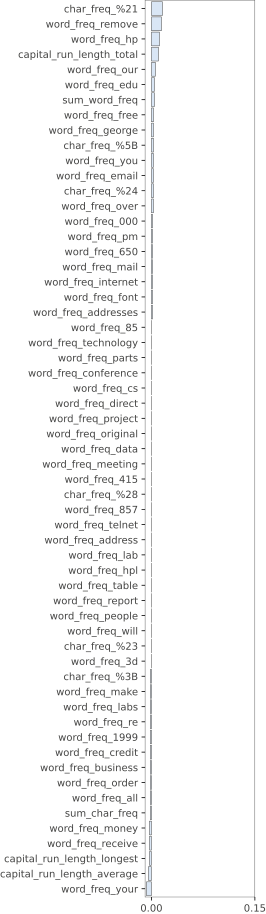

In [67]:
I = importances(rf, X_test, y_test)
plot_importances(I)

# Performance & Potential improvements:
### Final Model Interpretation
- Preformed well across multiple metrics. 
- Still classified too many Non-Spam emails as Spam 
- Yet tunning the model towards the highest precision will naturally increase the amount spam emails accidently landing in peoples inboxes.
- The key is to tune the model to find a balance here. I attempthed this with the f1 score during the crossvalidation and hyperparameter tunning. 

### Potential improvements:
- Tune model to reduce False Positives without losing too much on recall capabilites of the model